In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Web scrapping with google

In [ ]:
import csv
import json
import os

def csv_to_json(csv_file_path, json_file_path):
    # Open the CSV file
    with open(csv_file_path, 'r') as csv_file:
        # Read the CSV file using the DictReader class, assuming the first row contains headers
        csv_reader = csv.DictReader(csv_file)
        # Convert the CSV data to a list of dictionaries
        data = list(csv_reader)

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(json_file_path), exist_ok=True)

    # Write the data to a JSON file
    with open(json_file_path, 'w') as json_file:
        # Use the json.dump() function to write the data to the JSON file
        json.dump(data, json_file, indent=4)

# Example usage:
csv_file_path = '/content/drive/MyDrive/NLP_project/Bitcoin_tweets_dataset_2.csv'
json_file_path = '/content/drive/MyDrive/NLP_project/output.json'
csv_to_json(csv_file_path, json_file_path)

KeyboardInterrupt: 

In [15]:
df2 = pd.read_json('/content/drive/MyDrive/NLP_project/output.json')

In [ ]:
# Check for missing values
missing_values = df2['text'].isnull()

print(missing_values)

0         False
1         False
2         False
3         False
4         False
          ...  
174392    False
174393    False
174394    False
174395    False
174396    False
Name: text, Length: 174397, dtype: bool


In [ ]:
df2['date']

0         2023-03-01 23:59:59
1         2023-03-01 23:59:47
2         2023-03-01 23:59:42
3         2023-03-01 23:59:36
4         2023-03-01 23:59:32
                 ...         
174392    2023-03-04 10:51:00
174393    2023-03-04 10:50:48
174394    2023-03-04 10:50:29
174395    2023-03-04 10:50:17
174396    2023-03-04 10:50:14
Name: date, Length: 174397, dtype: object

In [16]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import nltk
nltk.download('punkt')
nltk.download('stopwords')


stopword_list = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
def preprocess_text(text):
    if text is not None:
        # Lowercasing
        text = text.lower()

        # Removing punctuation
        text = re.sub(r'[^\w\s]', '', text)

        # Lowercasing
        text = text.lower()

        # Removing hashtags (e.g., "#word")
        text = re.sub(r'#[A-Za-z0-9_]+', '', text)

        # Removing URLs starting with "http"
        text = re.sub(r"http\S+", "", text)

        # Removing URLs starting with "www"
        text = re.sub(r"www.\S+", "", text)

        # Removing special characters and punctuation
        text = re.sub(r'[()!?]', ' ', text)

        # Removing non-alphanumeric characters
        text = re.sub(r'[^a-z0-9]', ' ', text)

        # Tokenization
        tokens = word_tokenize(text)

        # Removing stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

        # Stemming
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]

        return ' '.join(tokens)
    else:
        return ''  # Return empty string if text is None

# Apply preprocessing function to the 'text' column of the DataFrame
df2['preprocessed_text'] = df2['text'].apply(preprocess_text)
df2['preprocessed_text'] = df2['preprocessed_text'].apply(lambda text: text.split())

In [18]:
preprocessed_texts = [' '.join(tokens) for tokens in df2['preprocessed_text']]
preprocessed_texts

['bitcoin book think read next',
 'thankgodforbtc appreci messag fan religi refer religion noth bitcoin',
 'ethereum price updat eth 166402 usd bitcoin 0070428 btc follow recent eth price updat altcoin cryptocurr crypto',
 'coindashboard v30 avail io android bitcoin',
 'bitcoin short term fractal 4h lower timefram btc price action seem repeat lmacd reproduc sequenc',
 'yall messag account recoveri hack cyber secur coinbas bitcoin bnb facebook snapchat instagram',
 'pump 4hour chart 1x normal coin filusdt entri 717 r1 817 122 r2 922 222 s1 686 43 time 01032023 2359 utc chart fil bitcoin fil',
 'twelvefold yugalab unveil uniqu bitcoin collect yuga lab team creat excit limitededit collect 300 gener piec piec inscrib satoshi bitcoin blockchain make truli uniqu collect nft',
 'bitcoinbullsnft first nft bitcoin',
 'first bitcoin halv age humbl time',
 'candl day 01032023 close open 2313094 high 2390602 low 2304267 close 2363596 chang 214 bitcoin candl bullmarket',
 'ub strategist predict min

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models
import pandas as pd
import seaborn as sns

# new TF-IDF Vectorizer
cv_tfidf = TfidfVectorizer(stop_words=stopword_list,max_df=0.08,min_df=0.004)
doc_word = cv_tfidf.fit_transform(preprocessed_texts)

print(doc_word.shape)

# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word.transpose())



(174397, 514)


In [21]:

id2word = dict((v, k) for k, v in cv_tfidf.vocabulary_.items())


lda = models.LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, passes=5, workers=1)


lda_corpus = lda[corpus]


lda_docs = [doc for doc in lda_corpus]


doc_cluster = [sorted(doc,key=lambda row:row[1])[::-1][0][0] for doc in lda_docs]
sns.barplot(x=pd.Series(doc_cluster).value_counts().keys(),y=pd.Series(doc_cluster).value_counts().values);

lda.print_topics()

Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/usr/local/lib/python3.10/dist-packages/gensim/models/ldamulticore.py", line 346, in worker_e_step
    worker_lda.do_estep(chunk)  # TODO: auto-tune alpha?
  File "/usr/local/lib/python3.10/dist-packages/gensim/models/ldamodel.py", line 768, in do_estep
    gamma, sstats = self.inference(chunk, collect_sstats=True)
  File "/usr/local/lib/python3.10/dist-packages/gensim/models/ldamodel.py", line 720, in inference
    Elogthetad = dirichlet_expectation(gammad)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 7.4 MB/s eta 0:00:00


In [ ]:
import pyLDAvis
import pyLDAvis.gensim
from gensim import corpora
id2word1 = corpora.Dictionary(df2['preprocessed_text'])
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, id2word, mds="mmds", R=10)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndexError: index 514 is out of bounds for axis 1 with size 514

In [22]:
topic_mapping={
                0:'Technical Analysis Signals',
                1:'Financial and Economic Discussion',
                2:'Trading and Market Sentiment',
                3:'Investment and Trends',
                4:'Market Analysis',
                5:'Different Cryptocurrency',
                6:'Binance Coin Related Discussion'  ,
                7:'Blockchain Projects and Tokens', #Venezuela has hyperinflation with national currency. People ruf off to cryptos
                8:'Market',
                9:'Art and NFTs',
                10:'Trading Details',
                }

In [ ]:
vec_topics = [lda_doc for lda_doc in lda_corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import operator

df_topics = []
for vec in vec_topics:
    sorted_x = sorted(vec, key=operator.itemgetter(1))
    sorted_x.reverse()
    df_topics.append(topic_mapping[sorted_x[0][0]])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df2['topics']= df_topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,preprocessed_text,topics
0,ChefSam,Sunshine State,Culinarian | Hot Sauce Artisan | Kombucha Brew...,2011-03-23 03:50:13,4680.0,2643.0,6232,False,2023-03-01 23:59:59,Which #bitcoin books should I think about read...,['bitcoin'],Twitter for iPhone,False,"[bitcoin, book, think, read, next]",Financial and Economic Discussion
1,Roy⚡️,,Truth-seeking pleb 📚 • Science 🧪 • Nature 🌱☀️ ...,2022-01-30 17:41:41,770.0,1145.0,9166,False,2023-03-01 23:59:47,"@ThankGodForBTC I appreciate the message, but ...",['Bitcoin'],Twitter for iPhone,False,"[thankgodforbtc, appreci, messag, fan, religi,...",Technical Analysis Signals
2,Ethereum Yoda,,UP or DOWN...\n.\n.\n.\n.\nPrice matters NOT.,2022-07-24 04:50:18,576.0,1.0,0,False,2023-03-01 23:59:42,#Ethereum price update: \n\n#ETH $1664.02 USD\...,"['Ethereum', 'ETH', 'Bitcoin', 'BTC', 'altcoin...",Twitter Web App,False,"[ethereum, price, updat, eth, 166402, usd, bit...",Art and NFTs
3,Viction,"Paris, France",https://t.co/8M3rgdjwEe\n\n#bitcoin #blockchai...,2010-03-26 10:15:26,236.0,1829.0,2195,False,2023-03-01 23:59:36,CoinDashboard v3.0 is here\nAvailable on ios a...,['Bitcoin'],Twitter for Android,False,"[coindashboard, v30, avail, io, android, bitcoin]",Binance Coin Related Discussion
4,Rosie,London,"The flower language of jasmine is loyalty, res...",2013-02-16 09:57:56,12731.0,46.0,134,False,2023-03-01 23:59:32,#Bitcoin Short Term Fractal (4H)💥\n\nIn lower ...,"['Bitcoin', 'BTC']",Twitter Web App,False,"[bitcoin, short, term, fractal, 4h, lower, tim...",Investment and Trends
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174392,GameFiDash | P2E Game | NFT | Web 3.0,,Homepage:https://t.co/tKbZ1UwZ9Q\nTelegram: ht...,2022-05-16 06:49:25,1633.0,1704.0,823,False,2023-03-04 10:51:00,#BTC Price $22338\n\n-RSI: 52\n-Moving Average...,['BTC'],Twitter Web App,False,"[btc, price, 22338, rsi, 52, move, average20, ...",Market Analysis
174393,Niklas Feurstein,Austria,"Blockchain Advocate👨‍💼, Programmer💻, Crypto En...",2016-01-11 19:45:21,7448.0,10.0,7341,False,2023-03-04 10:50:48,Jack Dorsey’s TBD launches ‘C=’ to improve Bit...,"['crypto', 'btc']",RSS Reader - Crypto Posts,False,"[jack, dorsey, tbd, launch, c, improv, bitcoin...",Investment and Trends
174394,ERROR.404 💱,SUPREME ORDER OF T.,"lil rude, forgive me..\n\n2020 / 2025 / 2028 /...",2010-07-17 02:09:19,421.0,428.0,20128,False,2023-03-04 10:50:29,@TheBlock__ Every holder in Celsius fcked 🤓\nT...,['BTC'],Twitter for Android,False,"[theblock, everi, holder, celsiu, fcked, conve...",Financial and Economic Discussion
174395,AI_Cryptominati/100x-1000x gems,sweden,Low of attraction/ I am a Crypto Millionaire! ...,2021-08-31 08:52:22,672.0,2031.0,465,False,2023-03-04 10:50:17,#btc #altcoin #short https://t.co/cAoqF22klA v...,"['btc', 'altcoin', 'short']",Twitter for iPhone,False,"[btc, altcoin, short, via, youtub, btc, price,...",Investment and Trends


In [ ]:
df2.to_json('/content/drive/MyDrive/NLP_project/output_topic_new.json')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
df3 = pd.read_json('/content/drive/MyDrive/NLP_project/output_topic_new.json')

In [23]:
df3

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,preprocessed_text,topics
0,ChefSam,Sunshine State,Culinarian | Hot Sauce Artisan | Kombucha Brew...,2011-03-23 03:50:13,4680.0,2643.0,6232,False,2023-03-01 23:59:59,Which #bitcoin books should I think about read...,['bitcoin'],Twitter for iPhone,False,"[bitcoin, book, think, read, next]",Financial and Economic Discussion
1,Roy⚡️,,Truth-seeking pleb 📚 • Science 🧪 • Nature 🌱☀️ ...,2022-01-30 17:41:41,770.0,1145.0,9166,False,2023-03-01 23:59:47,"@ThankGodForBTC I appreciate the message, but ...",['Bitcoin'],Twitter for iPhone,False,"[thankgodforbtc, appreci, messag, fan, religi,...",Technical Analysis Signals
2,Ethereum Yoda,,UP or DOWN...\n.\n.\n.\n.\nPrice matters NOT.,2022-07-24 04:50:18,576.0,1.0,0,False,2023-03-01 23:59:42,#Ethereum price update: \n\n#ETH $1664.02 USD\...,"['Ethereum', 'ETH', 'Bitcoin', 'BTC', 'altcoin...",Twitter Web App,False,"[ethereum, price, updat, eth, 166402, usd, bit...",Art and NFTs
3,Viction,"Paris, France",https://t.co/8M3rgdjwEe\n\n#bitcoin #blockchai...,2010-03-26 10:15:26,236.0,1829.0,2195,False,2023-03-01 23:59:36,CoinDashboard v3.0 is here\nAvailable on ios a...,['Bitcoin'],Twitter for Android,False,"[coindashboard, v30, avail, io, android, bitcoin]",Binance Coin Related Discussion
4,Rosie,London,"The flower language of jasmine is loyalty, res...",2013-02-16 09:57:56,12731.0,46.0,134,False,2023-03-01 23:59:32,#Bitcoin Short Term Fractal (4H)💥\n\nIn lower ...,"['Bitcoin', 'BTC']",Twitter Web App,False,"[bitcoin, short, term, fractal, 4h, lower, tim...",Investment and Trends
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174392,GameFiDash | P2E Game | NFT | Web 3.0,,Homepage:https://t.co/tKbZ1UwZ9Q\nTelegram: ht...,2022-05-16 06:49:25,1633.0,1704.0,823,False,2023-03-04 10:51:00,#BTC Price $22338\n\n-RSI: 52\n-Moving Average...,['BTC'],Twitter Web App,False,"[btc, price, 22338, rsi, 52, move, average20, ...",Market Analysis
174393,Niklas Feurstein,Austria,"Blockchain Advocate👨‍💼, Programmer💻, Crypto En...",2016-01-11 19:45:21,7448.0,10.0,7341,False,2023-03-04 10:50:48,Jack Dorsey’s TBD launches ‘C=’ to improve Bit...,"['crypto', 'btc']",RSS Reader - Crypto Posts,False,"[jack, dorsey, tbd, launch, c, improv, bitcoin...",Investment and Trends
174394,ERROR.404 💱,SUPREME ORDER OF T.,"lil rude, forgive me..\n\n2020 / 2025 / 2028 /...",2010-07-17 02:09:19,421.0,428.0,20128,False,2023-03-04 10:50:29,@TheBlock__ Every holder in Celsius fcked 🤓\nT...,['BTC'],Twitter for Android,False,"[theblock, everi, holder, celsiu, fcked, conve...",Financial and Economic Discussion
174395,AI_Cryptominati/100x-1000x gems,sweden,Low of attraction/ I am a Crypto Millionaire! ...,2021-08-31 08:52:22,672.0,2031.0,465,False,2023-03-04 10:50:17,#btc #altcoin #short https://t.co/cAoqF22klA v...,"['btc', 'altcoin', 'short']",Twitter for iPhone,False,"[btc, altcoin, short, via, youtub, btc, price,...",Investment and Trends


<ipython-input-6-f0c87525287e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df3['topics'].value_counts().keys(),


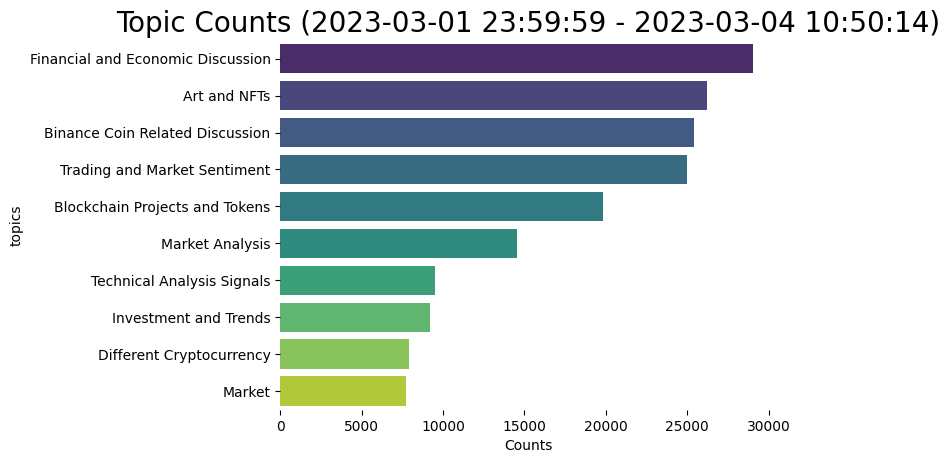

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(y=df3['topics'].value_counts().keys(),
            x=df3['topics'].value_counts().values,
            palette="viridis")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)


plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    s
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)

plt.xlabel('Counts')
plt.title('Topic Counts (2023-03-01 23:59:59 - 2023-03-04 10:50:14)');

Sentiment Analysis

In [ ]:
!pip install textblob
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.0 MB/s eta 0:00:00


In [ ]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

pos_list = ['rally', 'bounce', 'bullish', 'bull']
neg_list = ['bearish','bear','dip']


analyser = SentimentIntensityAnalyzer()


In [ ]:

def replace_terms(text, pos_list, neg_list):
    if text is None:
        return ''
    for word in pos_list:
        text = text.replace(word, 'good')
    for word in neg_list:
        text = text.replace(word, 'bad')
    return text

def get_vader_sentiment(text):
    return analyser.polarity_scores(text)

def get_textblob_sentiment(text):
    return np.round(TextBlob(text).sentiment.polarity, 4)

In [ ]:
df3['text'] = df3['text'].apply(replace_terms, args=(pos_list, neg_list))

df3['vader_sentiment'] = df3['text'].apply(get_vader_sentiment)
df3['vader_compound'] = df3['vader_sentiment'].apply(lambda x: x['compound'])

df3['textblob_sentiment'] = df3['text'].apply(get_textblob_sentiment)

df3['vader+textblob_sentiment'] = (df3['vader_compound'] + df3['textblob_sentiment'])/2

In [ ]:
df3.to_json('/content/drive/MyDrive/NLP_project/output_sentiment_new.json')

Concat Bitcoin Dataset and Sentiment Dataset

In [ ]:
#
bitcoin_price = pd.read_csv('/content/drive/MyDrive/NLP_project/BTCUSDT.csv', header=None)


bitcoin_price = bitcoin_price[0].str.split('|', expand=True)

bitcoin_price.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']


bitcoin_price['date'] = pd.to_datetime(bitcoin_price['date'], unit='s')


start_date = '2023-02-25 20:48:00'
end_date = '2023-03-05 23:58:00'

filtered_bitcoin_price = bitcoin_price[(bitcoin_price['date'] >= start_date) & (bitcoin_price['date'] <= end_date)]

<ipython-input-42-90c543fbd1b7>:11: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  bitcoin_price['date'] = pd.to_datetime(bitcoin_price['date'], unit='s')


In [ ]:
filtered_bitcoin_price[0:1000]

,date,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
2898446,2023-02-25 20:48:00,22834.59,22861.99,22819.65,22840.95,457.42579,4935651.64427,216.06785,10448508.87007,16508
2898447,2023-02-25 20:48:00,22842.16,22856.68,22800.16,22851.26,356.64211,4373677.48511,191.50823,8144584.70201,12940
2898448,2023-02-25 20:48:00,22851.26,22855.85,22813.10,22833.59,249.47698,2560199.16012,112.13824,5696046.05696,9685
2898449,2023-02-25 20:50:08,22835.02,22889.10,22828.98,22883.79,294.81871,3880225.41484,169.70109,6741158.76258,10126
2898450,2023-02-25 20:50:08,22883.79,22931.20,22877.58,22924.24,519.52214,5966188.81972,260.40715,11903002.41168,16851
...,...,...,...,...,...,...,...,...,...,...
2899441,2023-02-26 13:22:08,23168.42,23179.42,23166.29,23175.78,79.17780,983956.17681,42.46023,1834811.66545,5519
2899442,2023-02-26 13:22:08,23175.78,23184.45,23173.19,23179.64,111.41513,1236795.03163,53.35798,2582484.57193,5399
2899443,2023-02-26 13:24:16,23179.64,23183.35,23174.00,23176.50,88.26005,907477.15563,39.15091,2045779.94323,3809
2899444,2023-02-26 13:24:16,23177.07,23183.56,23168.99,23170.76,103.84507,1095341.33156,47.25836,2406796.78421,4202


In [ ]:
filtered_bitcoin_price = filtered_bitcoin_price.applymap(lambda x: float(x.replace(' ', '')) if isinstance(x, str) else x)

filtered_bitcoin_price.set_index('date', inplace=True)


filtered_bitcoin_price_2min_mean = filtered_bitcoin_price.resample('2T').mean()


filtered_bitcoin_price_2min_mean.reset_index(inplace=True)

In [ ]:
filtered_bitcoin_price_2min_mean

,date,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2023-02-25 20:48:00,22842.670,22858.173333,22810.970,22841.933333,354.514960,3.956509e+06,173.238107,8.096380e+06,13044.333333
1,2023-02-25 20:50:00,22859.405,22910.150000,22853.280,22904.015000,407.170425,4.923207e+06,215.054120,9.322081e+06,13488.500000
2,2023-02-25 20:52:00,22917.785,22942.890000,22904.145,22912.320000,377.373975,4.392998e+06,191.618285,8.651658e+06,10845.000000
3,2023-02-25 20:54:00,22924.135,22940.590000,22911.295,22928.140000,219.489660,2.499829e+06,109.045065,5.031762e+06,7768.500000
4,2023-02-25 20:56:00,22920.410,22937.460000,22911.605,22914.475000,173.289295,1.986851e+06,86.668470,3.972438e+06,8228.000000
...,...,...,...,...,...,...,...,...,...,...
5850,2023-03-05 23:48:00,22410.230,22419.660000,22408.770,22416.655000,77.134560,9.918999e+05,44.244465,1.729230e+06,2714.000000
5851,2023-03-05 23:50:00,22422.365,22427.725000,22417.075,22419.075000,63.632805,6.937663e+05,30.939250,1.426837e+06,2682.000000
5852,2023-03-05 23:52:00,22423.970,22437.780000,22422.125,22433.475000,108.478525,1.310763e+06,58.439085,2.433076e+06,3556.000000
5853,2023-03-05 23:54:00,22433.125,22435.745000,22426.160,22429.975000,65.710420,6.615407e+05,29.494175,1.473817e+06,2622.500000


In [63]:
df4 = pd.read_json('/content/drive/MyDrive/NLP_project/output_sentiment_new.json')

In [64]:
df4

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,preprocessed_text,topics,vader_sentiment,textblob_sentiment,vader_compound,vader+textblob_sentiment
0,ChefSam,Sunshine State,Culinarian | Hot Sauce Artisan | Kombucha Brew...,2011-03-23 03:50:13,4680.0,2643.0,6232,False,2023-03-01 23:59:59,Which #bitcoin books should I think about read...,['bitcoin'],Twitter for iPhone,False,"[bitcoin, book, think, read, next]",Financial and Economic Discussion,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0000,0.00000
1,Roy⚡️,,Truth-seeking pleb 📚 • Science 🧪 • Nature 🌱☀️ ...,2022-01-30 17:41:41,770.0,1145.0,9166,False,2023-03-01 23:59:47,"@ThankGodForBTC I appreciate the message, but ...",['Bitcoin'],Twitter for iPhone,False,"[thankgodforbtc, appreci, messag, fan, religi,...",Technical Analysis Signals,"{'neg': 0.11, 'neu': 0.807, 'pos': 0.083, 'com...",0.0000,-0.1513,-0.07565
2,Ethereum Yoda,,UP or DOWN...\n.\n.\n.\n.\nPrice matters NOT.,2022-07-24 04:50:18,576.0,1.0,0,False,2023-03-01 23:59:42,#Ethereum price update: \n\n#ETH $1664.02 USD\...,"['Ethereum', 'ETH', 'Bitcoin', 'BTC', 'altcoin...",Twitter Web App,False,"[ethereum, price, updat, eth, 166402, usd, bit...",Art and NFTs,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0000,0.00000
3,Viction,"Paris, France",https://t.co/8M3rgdjwEe\n\n#bitcoin #blockchai...,2010-03-26 10:15:26,236.0,1829.0,2195,False,2023-03-01 23:59:36,CoinDashboard v3.0 is here\nAvailable on ios a...,['Bitcoin'],Twitter for Android,False,"[coindashboard, v30, avail, io, android, bitcoin]",Binance Coin Related Discussion,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.4000,0.0000,0.20000
4,Rosie,London,"The flower language of jasmine is loyalty, res...",2013-02-16 09:57:56,12731.0,46.0,134,False,2023-03-01 23:59:32,#Bitcoin Short Term Fractal (4H)💥\n\nIn lower ...,"['Bitcoin', 'BTC']",Twitter Web App,False,"[bitcoin, short, term, fractal, 4h, lower, tim...",Investment and Trends,"{'neg': 0.164, 'neu': 0.836, 'pos': 0.0, 'comp...",0.0333,-0.5719,-0.26930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174392,GameFiDash | P2E Game | NFT | Web 3.0,,Homepage:https://t.co/tKbZ1UwZ9Q\nTelegram: ht...,2022-05-16 06:49:25,1633.0,1704.0,823,False,2023-03-04 10:51:00,#BTC Price $22338\n\n-RSI: 52\n-Moving Average...,['BTC'],Twitter Web App,False,"[btc, price, 22338, rsi, 52, move, average20, ...",Market Analysis,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0000,0.00000
174393,Niklas Feurstein,Austria,"Blockchain Advocate👨‍💼, Programmer💻, Crypto En...",2016-01-11 19:45:21,7448.0,10.0,7341,False,2023-03-04 10:50:48,Jack Dorsey’s TBD launches ‘C=’ to improve Bit...,"['crypto', 'btc']",RSS Reader - Crypto Posts,False,"[jack, dorsey, tbd, launch, c, improv, bitcoin...",Investment and Trends,"{'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'comp...",0.0000,0.4404,0.22020
174394,ERROR.404 💱,SUPREME ORDER OF T.,"lil rude, forgive me..\n\n2020 / 2025 / 2028 /...",2010-07-17 02:09:19,421.0,428.0,20128,False,2023-03-04 10:50:29,@TheBlock__ Every holder in Celsius fcked 🤓\nT...,['BTC'],Twitter for Android,False,"[theblock, everi, holder, celsiu, fcked, conve...",Financial and Economic Discussion,"{'neg': 0.108, 'neu': 0.892, 'pos': 0.0, 'comp...",0.0000,-0.4184,-0.20920
174395,AI_Cryptominati/100x-1000x gems,sweden,Low of attraction/ I am a Crypto Millionaire! ...,2021-08-31 08:52:22,672.0,2031.0,465,False,2023-03-04 10:50:17,#btc #altcoin #short https://t.co/cAoqF22klA v...,"['btc', 'altcoin', 'short']",Twitter for iPhone,False,"[btc, altcoin, short, via, youtub, btc, price,...",Investment and Trends,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0000,0.00000


In [57]:
df4.columns


Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet', 'preprocessed_text',
       'topics', 'vader_sentiment', 'textblob_sentiment', 'vader_compound',
       'vader+textblob_sentiment'],
      dtype='object')

In [59]:
df4 = df4[['date','vader_compound', 'textblob_sentiment', 'vader+textblob_sentiment']]

df4['date'] = pd.to_datetime(df4['date'], errors = 'coerce')

df4.set_index('date', inplace=True)


df2min_mean = df4.resample('2T').mean()

df2min_mean.reset_index(inplace=True)



KeyError: "['date'] not in index"

In [ ]:
df2min_mean

df2min_mean.drop(df2min_mean.tail(1).index,
        inplace = True)

In [ ]:
df2min_mean.set_index(filtered_bitcoin_price_2min_mean.index, inplace=True)

concatenated_df = pd.concat([df2min_mean, filtered_bitcoin_price_2min_mean[['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']]], axis=1)

In [ ]:
# Price change for 2 minutes (in percentage)
concatenated_df['2min_price_change_percentage'] = (concatenated_df['close'] - concatenated_df['close'].shift(1)) / concatenated_df['close'].shift(1)

# Price change for 4 minutes (in percentage)
concatenated_df['4min_price_change_percentage'] = (concatenated_df['close'] - concatenated_df['close'].shift(2)) / concatenated_df['close'].shift(2)

# Price change for 1 hour (assuming each minute is represented) (in percentage)
concatenated_df['1hour_price_change_percentage'] = (concatenated_df['close'] - concatenated_df['close'].shift(60)) / concatenated_df['close'].shift(60)

# Price change for 1 day (assuming each minute is represented) (in percentage)
concatenated_df['1day_price_change_percentage'] = (concatenated_df['close'] - concatenated_df['close'].shift(60 * 24)) / concatenated_df['close'].shift(60 * 24)

# Sentiment change for 2 minutes (in percentage)
concatenated_df['2min_sentiment_change_percentage'] = (concatenated_df['vader+textblob_sentiment'] - concatenated_df['vader+textblob_sentiment'].shift(1)) / concatenated_df['vader+textblob_sentiment'].shift(1)

# Sentiment change for 4 minutes (in percentage)
concatenated_df['4min_sentiment_change_percentage'] = (concatenated_df['vader+textblob_sentiment'] - concatenated_df['vader+textblob_sentiment'].shift(2)) / concatenated_df['vader+textblob_sentiment'].shift(2)

# Sentiment change for 1 hour (assuming each minute is represented) (in percentage)
concatenated_df['1hour_sentiment_change_percentage'] = (concatenated_df['vader+textblob_sentiment'] - concatenated_df['vader+textblob_sentiment'].shift(60)) / concatenated_df['vader+textblob_sentiment'].shift(60)

# Sentiment change for 1 day (assuming each minute is represented) (in percentage)
concatenated_df['1day_sentiment_change_percentage'] = (concatenated_df['vader+textblob_sentiment'] - concatenated_df['vader+textblob_sentiment'].shift(60 * 24)) / concatenated_df['vader+textblob_sentiment'].shift(60 * 24)

# Price change for 1 week (assuming each minute is represented) (in percentage)
concatenated_df['1week_price_change_percentage'] = (concatenated_df['close'] - concatenated_df['close'].shift(60 * 24 * 7)) / concatenated_df['close'].shift(60 * 24 * 7)

# Sentiment change for 1 week (assuming each minute is represented) (in percentage)
concatenated_df['1week_sentiment_change_percentage'] = (concatenated_df['vader+textblob_sentiment'] - concatenated_df['vader+textblob_sentiment'].shift(60 * 24 * 7)) / concatenated_df['vader+textblob_sentiment'].shift(60 * 24 * 7)

In [ ]:

concatenated_df

In [ ]:
concatenated_df.to_json(r'/content/drive/MyDrive/NLP_project/final.json')



Visualisation

In [4]:
final_df = pd.read_json('/content/drive/MyDrive/NLP_project/final.json')

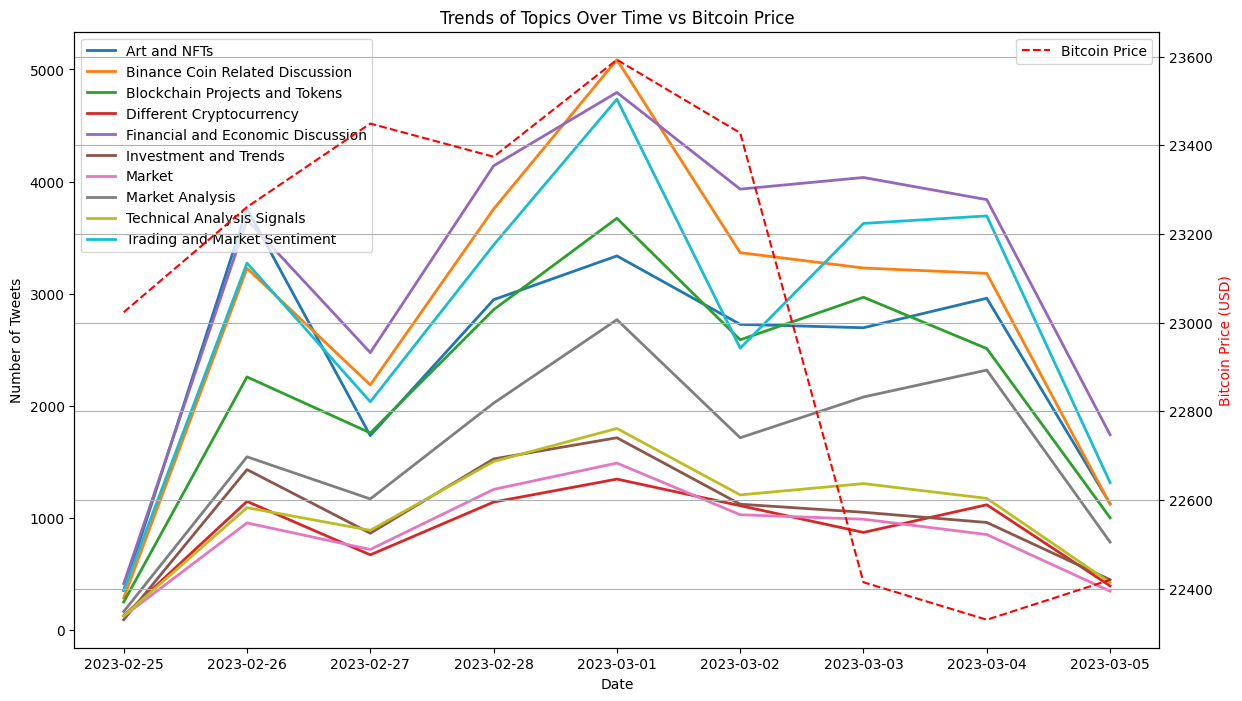

In [66]:

df4['date'] = pd.to_datetime(df4['date'], errors = 'coerce')

topic_trends = df4.groupby([df4['date'].dt.date, 'topics']).size().unstack(fill_value=0)


bitcoin_daily = final_df.set_index('date').resample('D').mean()


fig, ax1 = plt.subplots(figsize=(14, 8))


topic_trends.plot(ax=ax1, linewidth=2)


ax2 = ax1.twinx()
ax2.plot(bitcoin_daily.index, bitcoin_daily['close'], color='red', linestyle='--', label='Bitcoin Price')
ax2.set_ylabel('Bitcoin Price (USD)', color='red')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Tweets')
ax1.set_title('Trends of Topics Over Time vs Bitcoin Price')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid()

plt.show()

In [ ]:
final_df

,date,vader_compound,textblob_sentiment,vader+textblob_sentiment,open,high,low,close,volume,quote_asset_volume,...,2min_price_change_percentage,4min_price_change_percentage,1hour_price_change_percentage,1day_price_change_percentage,2min_sentiment_change_percentage,4min_sentiment_change_percentage,1hour_sentiment_change_percentage,1day_sentiment_change_percentage,1week_price_change_percentage,1week_sentiment_change_percentage
0,2023-02-25 20:48:00,0.239361,0.135861,0.187611,22842.670,22858.173333,22810.970,22841.933333,354.514960,3.956509e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-02-25 20:50:00,0.105150,0.084935,0.095042,22859.405,22910.150000,22853.280,22904.015000,407.170425,4.923207e+06,...,0.002718,NaN,NaN,NaN,-0.493408,NaN,NaN,NaN,NaN,NaN
2,2023-02-25 20:52:00,0.289106,0.089376,0.189241,22917.785,22942.890000,22904.145,22912.320000,377.373975,4.392998e+06,...,0.000363,0.003081,NaN,NaN,0.991123,0.008687,NaN,NaN,NaN,NaN
3,2023-02-25 20:54:00,0.190533,0.074640,0.132587,22924.135,22940.590000,22911.295,22928.140000,219.489660,2.499829e+06,...,0.000690,0.001053,NaN,NaN,-0.299376,0.395028,NaN,NaN,NaN,NaN
4,2023-02-25 20:56:00,0.150592,0.063500,0.107046,22920.410,22937.460000,22911.605,22914.475000,173.289295,1.986851e+06,...,-0.000596,0.000094,NaN,NaN,-0.192635,-0.434341,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5850,2023-03-05 23:48:00,0.198726,0.058889,0.128808,22410.230,22419.660000,22408.770,22416.655000,77.134560,9.918999e+05,...,0.000358,0.000490,0.000712,0.003081,0.143847,0.005076,0.246270,-0.026763,NaN,NaN
5851,2023-03-05 23:50:00,0.139670,0.126717,0.133193,22422.365,22427.725000,22417.075,22419.075000,63.632805,6.937663e+05,...,0.000108,0.000466,NaN,0.003299,0.034047,0.182792,0.015415,1.265195,NaN,NaN
5852,2023-03-05 23:52:00,0.110153,0.148677,0.129415,22423.970,22437.780000,22422.125,22433.475000,108.478525,1.310763e+06,...,0.000642,0.000750,0.000950,0.004325,-0.028368,0.004713,-0.504787,0.260556,NaN,NaN
5853,2023-03-05 23:54:00,0.256688,0.174169,0.215428,22433.125,22435.745000,22426.160,22429.975000,65.710420,6.615407e+05,...,-0.000156,0.000486,-0.002097,0.003866,0.664630,0.617407,1.044621,0.112073,NaN,NaN


In [ ]:
concatenated_df = pd.concat([df2min_mean, filtered_bitcoin_price_2min_mean[['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']]], axis=1)

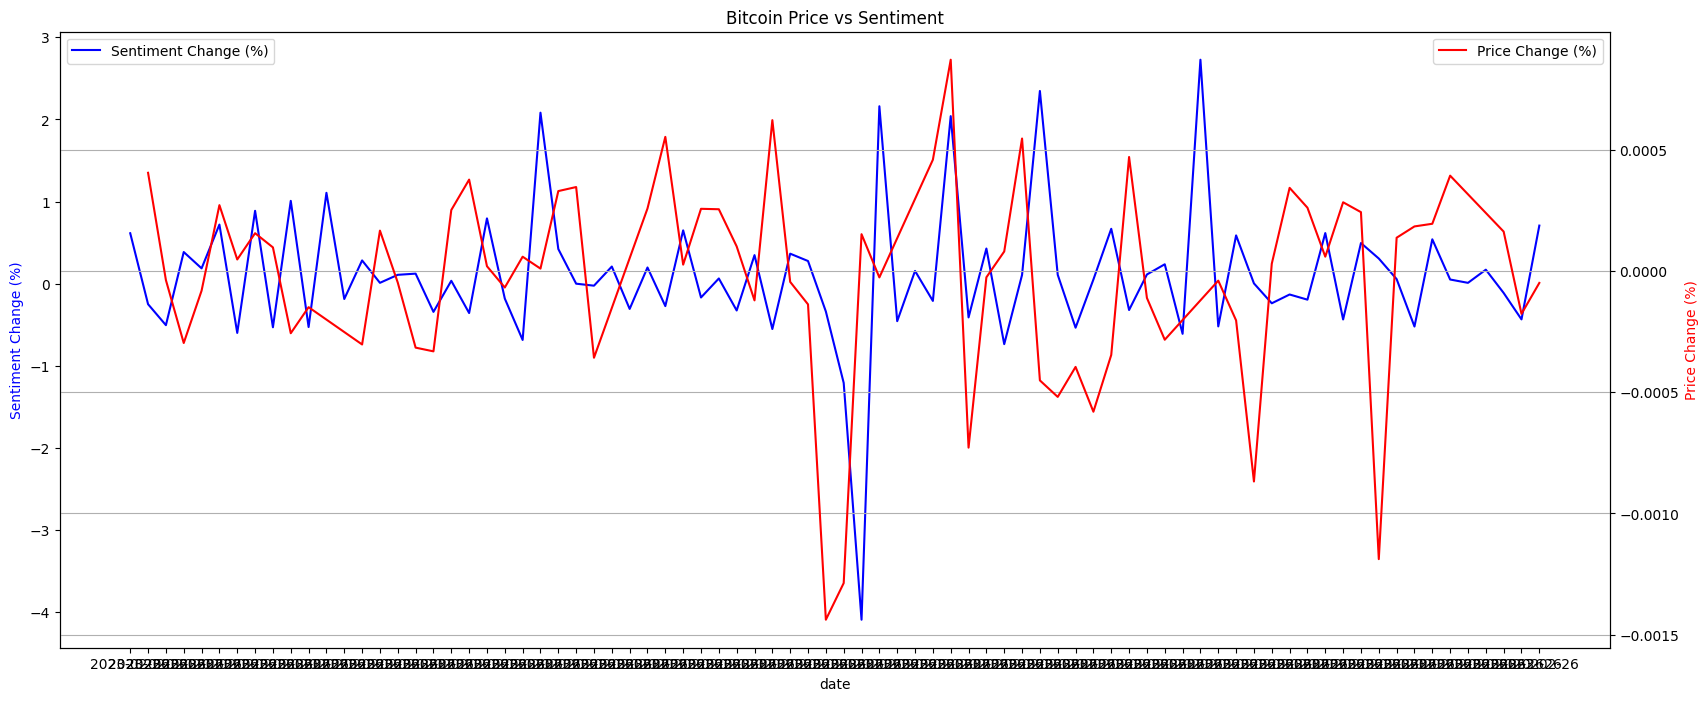

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


start_index = 420
end_index = 500


fig, ax1 = plt.subplots(figsize=(20, 8))


sns.lineplot(x=final_df['date'][start_index:end_index], y=final_df['2min_sentiment_change_percentage'][start_index:end_index], ax=ax1, color='blue', label='Sentiment Change (%)')


ax1.set_ylabel('Sentiment Change (%)', color='blue')


ax2 = ax1.twinx()
sns.lineplot(x=final_df['date'][start_index+1:end_index+1], y=final_df['2min_price_change_percentage'][start_index:end_index], ax=ax2, color='red', label='Price Change (%)')

ax2.set_ylabel('Price Change (%)', color='red')


plt.title('Bitcoin Price vs Sentiment')


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xticks(final_df['date'][start_index:end_index], rotation=45)


plt.grid()

plt.show()

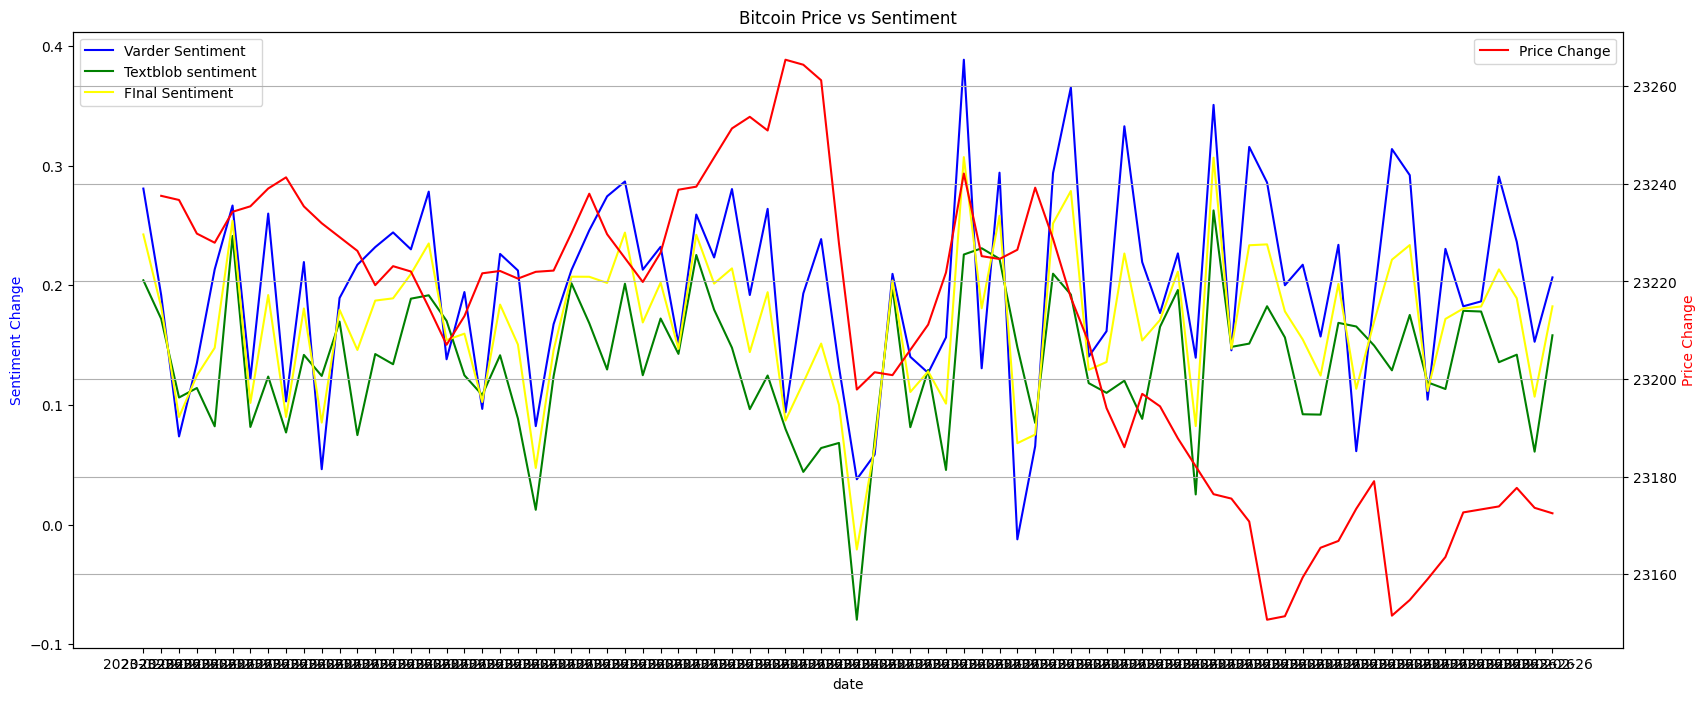

In [9]:

start_index = 420
end_index = 500


fig, ax1 = plt.subplots(figsize=(20, 8))


sns.lineplot(x=final_df['date'][start_index:end_index], y=final_df['vader_compound'][start_index:end_index], ax=ax1, color='blue', label='Varder Sentiment')
sns.lineplot(x=final_df['date'][start_index:end_index], y=final_df['textblob_sentiment'][start_index:end_index], ax=ax1, color='green', label='Textblob sentiment')
sns.lineplot(x=final_df['date'][start_index:end_index], y=final_df['vader+textblob_sentiment'][start_index:end_index], ax=ax1, color='yellow', label='FInal Sentiment')


ax1.set_ylabel('Sentiment Change', color='blue')


ax2 = ax1.twinx()
sns.lineplot(x=final_df['date'][start_index+1:end_index+1], y=final_df['close'][start_index:end_index], ax=ax2, color='red', label='Price Change')


ax2.set_ylabel('Price Change', color='red')


plt.title('Bitcoin Price vs Sentiment')


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xticks(final_df['date'][start_index:end_index], rotation=45)


plt.grid()


plt.show()

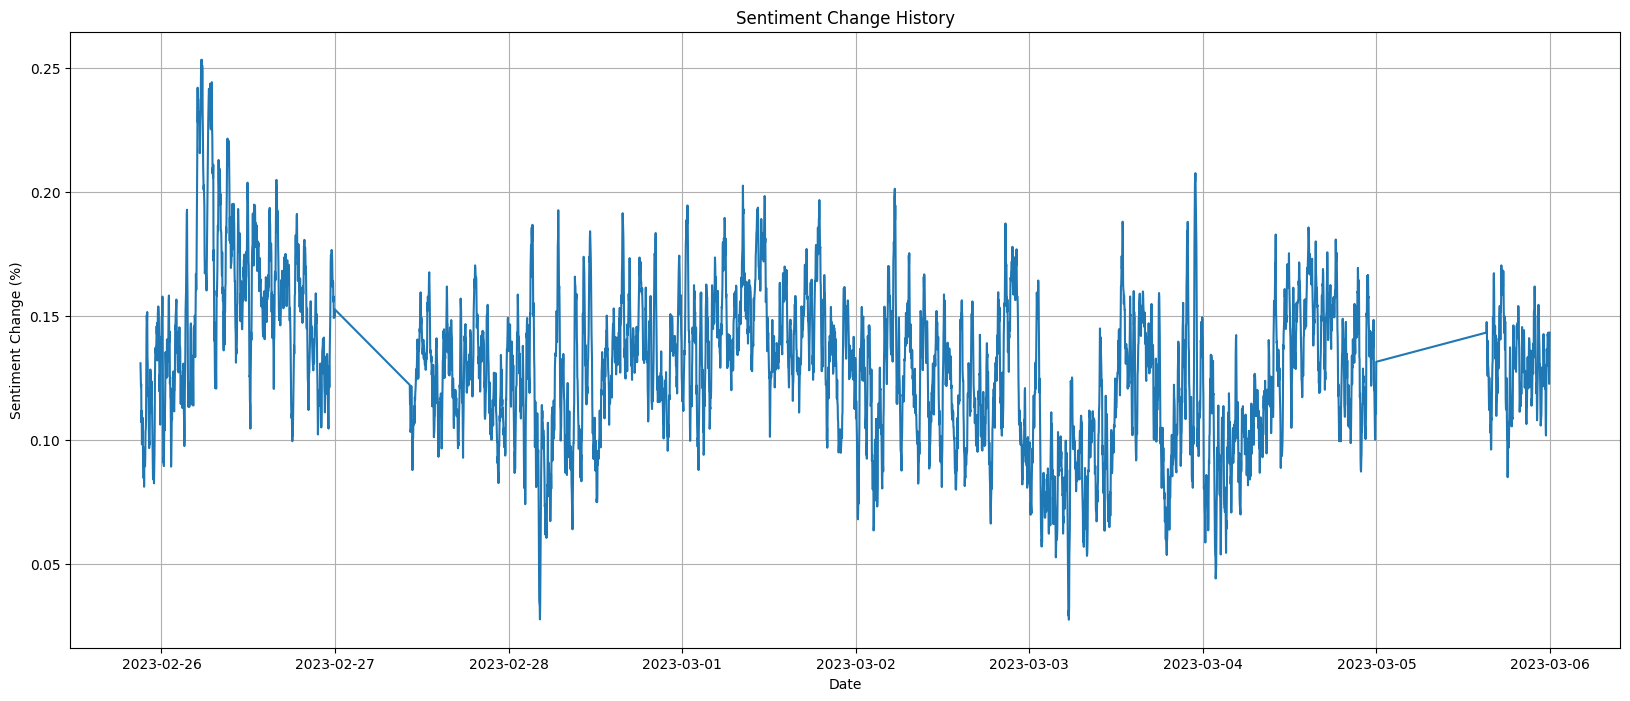

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(x=final_df['date'],y=final_df['vader+textblob_sentiment'].rolling(10).mean())
plt.xlabel('Date')
plt.ylabel('Sentiment Change (%)')
plt.title('Sentiment Change History')
plt.grid()

Text(0.5, 1.0, 'Raw Sentiment Distribution')

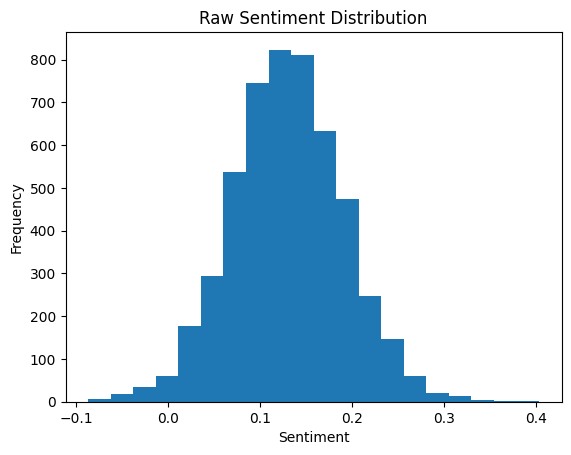

In [ ]:
plt.hist(final_df['vader+textblob_sentiment'],bins=20)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Raw Sentiment Distribution')

LDA Vector merge with final datast

In [ ]:
# Assuming lda_docs is a list of topic vectors for each document
# Create a DataFrame from lda_docs
df_lda_docs = pd.DataFrame(lda_docs)

In [ ]:
for column in df_lda_docs.columns:
    df_lda_docs[column] = df_lda_docs[column].apply(lambda x: x[1])

# Rename the columns
df_lda_docs.rename(columns={
    0: 'topic_1',
    1: 'topic_2',
    2: 'topic_3',
    3: 'topic_4',
    4: 'topic_5',
    5: 'topic_6',
    6: 'topic_7',
    7: 'topic_8',
    8: 'topic_9',
    9: 'topic_10'
}, inplace=True)

df_lda_docs

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,0.669455,0.036722,0.036727,0.036727,0.036733,0.036725,0.036737,0.036722,0.036722,0.036730
1,0.050001,0.050001,0.050001,0.050001,0.549989,0.050001,0.050001,0.050001,0.050001,0.050001
2,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
3,0.041433,0.041433,0.627088,0.041433,0.041445,0.041433,0.041433,0.041433,0.041433,0.041434
4,0.267660,0.036680,0.036680,0.036680,0.036680,0.438902,0.036680,0.036680,0.036680,0.036680
...,...,...,...,...,...,...,...,...,...,...
174392,0.027486,0.752630,0.027486,0.027485,0.027486,0.027485,0.027486,0.027485,0.027485,0.027485
174393,0.036630,0.036630,0.463124,0.036629,0.036629,0.036629,0.036633,0.036655,0.243801,0.036640
174394,0.751966,0.027548,0.027563,0.027548,0.027558,0.027548,0.027599,0.027567,0.027548,0.027557
174395,0.041455,0.041454,0.319210,0.041454,0.041456,0.349141,0.041466,0.041458,0.041454,0.041454


In [ ]:
# Concatenate df_lda_docs with df2 along the columns
concatenated_df2 = pd.concat([df2, df_lda_docs], axis=1)

In [ ]:

columns_to_select = ['date', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']

concatenated_df2 = concatenated_df2[columns_to_select]

concatenated_df2['date'] = pd.to_datetime(concatenated_df2['date'], error ='coerce')
concatenated_df2.set_index('date', inplace=True)

concatenated_df2_2min_mean = concatenated_df2.resample('2T').mean()

concatenated_df2_2min_mean.reset_index(inplace=True)

In [ ]:
concatenated_df2_2min_mean.drop(concatenated_df2_2min_mean.tail(1).index,
        inplace = True)

concatenated_df2_2min_mean.drop(columns=['date'], inplace=True)

In [ ]:
final_df = pd.concat([final_df, concatenated_df2_2min_mean], axis=1)

In [ ]:
final_df

,date,vader_compound,textblob_sentiment,vader+textblob_sentiment,open,high,low,close,volume,quote_asset_volume,...,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,2023-02-25 20:48:00,0.239361,0.135861,0.187611,22842.670,22858.173333,22810.970,22841.933333,354.514960,3.956509e+06,...,0.332220,0.081571,0.124624,0.040583,0.043596,0.075113,0.047405,0.106156,0.072099,0.076631
1,2023-02-25 20:50:00,0.105150,0.084935,0.095042,22859.405,22910.150000,22853.280,22904.015000,407.170425,4.923207e+06,...,0.139025,0.127611,0.102020,0.126091,0.078754,0.101121,0.045004,0.109012,0.071070,0.100290
2,2023-02-25 20:52:00,0.289106,0.089376,0.189241,22917.785,22942.890000,22904.145,22912.320000,377.373975,4.392998e+06,...,0.153203,0.079797,0.109126,0.036160,0.149629,0.085962,0.045324,0.119401,0.108069,0.113330
3,2023-02-25 20:54:00,0.190533,0.074640,0.132587,22924.135,22940.590000,22911.295,22928.140000,219.489660,2.499829e+06,...,0.193903,0.085739,0.102926,0.090581,0.125014,0.087897,0.071186,0.079352,0.094747,0.068655
4,2023-02-25 20:56:00,0.150592,0.063500,0.107046,22920.410,22937.460000,22911.605,22914.475000,173.289295,1.986851e+06,...,0.250877,0.068191,0.087891,0.066833,0.065559,0.168050,0.047958,0.083440,0.073919,0.087282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5850,2023-03-05 23:48:00,0.198726,0.058889,0.128808,22410.230,22419.660000,22408.770,22416.655000,77.134560,9.918999e+05,...,0.182406,0.052796,0.108410,0.086807,0.128029,0.073907,0.084291,0.064682,0.111220,0.107453
5851,2023-03-05 23:50:00,0.139670,0.126717,0.133193,22422.365,22427.725000,22417.075,22419.075000,63.632805,6.937663e+05,...,0.132757,0.094832,0.070888,0.095408,0.114729,0.056927,0.142830,0.061067,0.088381,0.142181
5852,2023-03-05 23:52:00,0.110153,0.148677,0.129415,22423.970,22437.780000,22422.125,22433.475000,108.478525,1.310763e+06,...,0.246890,0.076150,0.091339,0.103721,0.125915,0.068693,0.094753,0.060690,0.047880,0.083968
5853,2023-03-05 23:54:00,0.256688,0.174169,0.215428,22433.125,22435.745000,22426.160,22429.975000,65.710420,6.615407e+05,...,0.117781,0.134220,0.093237,0.082752,0.123037,0.081909,0.069440,0.069337,0.075103,0.153184


In [ ]:
final_df.to_json('/content/drive/MyDrive/NLP_project/final_with_lda.json')

Train LSTM

In [78]:
final_df_lda = pd.read_json('/content/drive/MyDrive/NLP_project/final_with_lda.json')

In [79]:
final_df_lda.columns

Index(['date', 'vader_compound', 'textblob_sentiment',
       'vader+textblob_sentiment', 'open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', '4min_change', '1hour_change',
       '1day_change', '1week_change', '2min_change', '2min_price_change',
       '4min_price_change', '1hour_price_change', '1day_price_change',
       '2min_sentiment_change', '4min_sentiment_change',
       '1hour_sentiment_change', '1day_sentiment_change', '1week_price_change',
       '1week_sentiment_change', '2min_price_change_percentage',
       '4min_price_change_percentage', '1hour_price_change_percentage',
       '1day_price_change_percentage', '2min_sentiment_change_percentage',
       '4min_sentiment_change_percentage', '1hour_sentiment_change_percentage',
       '1day_sentiment_change_percentage', '1week_price_change_percentage',
       '1week_sentiment_change_percentage', 'topic_1', 'topic_2', 't

In [80]:

columns_to_fill = ['vader_compound', 'textblob_sentiment', 'vader+textblob_sentiment',
                   'open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
                   'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']


row_median = final_df_lda[columns_to_fill].median(axis=1)

# Replace missing values with row-wise median
final_df_lda[columns_to_fill] = final_df_lda[columns_to_fill].fillna(row_median, axis=0)

In [81]:

columns_to_fill_zero = ['4min_change', '1hour_change', '1day_change', '1week_change',
                        '2min_change', '2min_price_change', '4min_price_change',
                        '1hour_price_change', '1day_price_change', '2min_sentiment_change',
                        '4min_sentiment_change', '1hour_sentiment_change', '1day_sentiment_change',
                        '1week_price_change', '1week_sentiment_change', '2min_price_change_percentage',
                        '4min_price_change_percentage', '1hour_price_change_percentage',
                        '1day_price_change_percentage', '2min_sentiment_change_percentage',
                        '4min_sentiment_change_percentage', '1hour_sentiment_change_percentage',
                        '1day_sentiment_change_percentage', '1week_price_change_percentage',

final_df_lda[columns_to_fill_zero] = final_df_lda[columns_to_fill_zero].fillna(0)

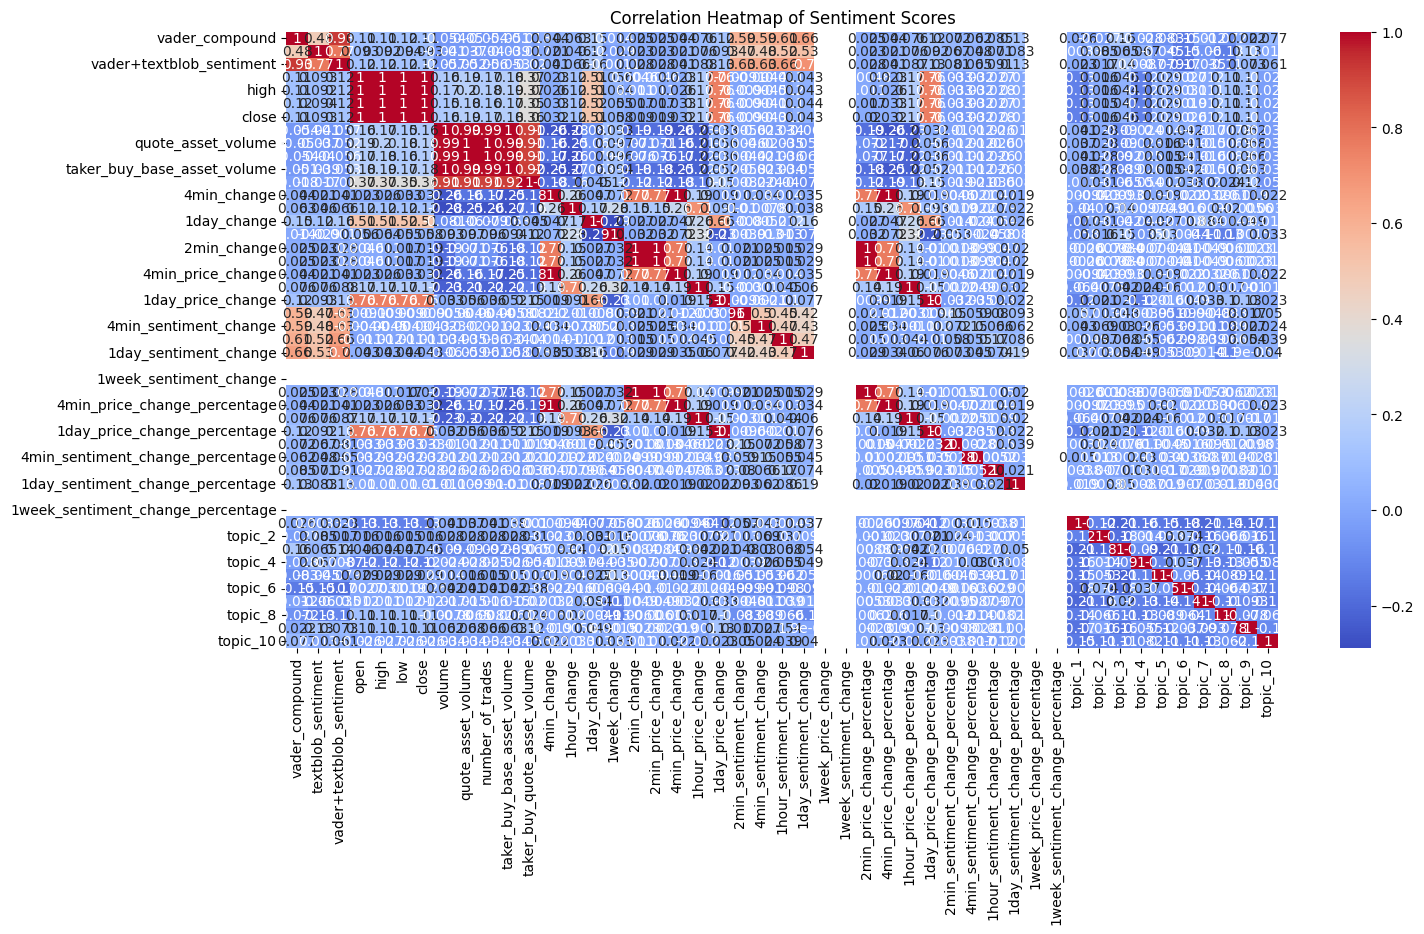

In [71]:
correlation_matrix = final_df_lda[[
    'vader_compound', 'textblob_sentiment', 'vader+textblob_sentiment', 'open', 'high', 'low', 'close', 'volume',
    'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
    '4min_change', '1hour_change', '1day_change', '1week_change', '2min_change', '2min_price_change',
    '4min_price_change', '1hour_price_change', '1day_price_change', '2min_sentiment_change', '4min_sentiment_change',
    '1hour_sentiment_change', '1day_sentiment_change', '1week_price_change', '1week_sentiment_change',
    '2min_price_change_percentage', '4min_price_change_percentage', '1hour_price_change_percentage',
    '1day_price_change_percentage', '2min_sentiment_change_percentage', '4min_sentiment_change_percentage',
    '1hour_sentiment_change_percentage', '1day_sentiment_change_percentage', '1week_price_change_percentage',
    '1week_sentiment_change_percentage', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6',
    'topic_7', 'topic_8', 'topic_9', 'topic_10'
]].corr()
plt.figure(figsize=(16, 8))  # Set the figure size to 16x8 inches
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Sentiment Scores')
plt.show()

,date,vader_compound,textblob_sentiment,vader+textblob_sentiment,open,high,low,close,volume,quote_asset_volume,...,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,2023-02-25 20:48:00,0.239361,0.135861,0.187611,22842.670,22858.173333,22810.970,22841.933333,354.514960,3.956509e+06,...,0.332220,0.081571,0.124624,0.040583,0.043596,0.075113,0.047405,0.106156,0.072099,0.076631
1,2023-02-25 20:50:00,0.105150,0.084935,0.095042,22859.405,22910.150000,22853.280,22904.015000,407.170425,4.923207e+06,...,0.139025,0.127611,0.102020,0.126091,0.078754,0.101121,0.045004,0.109012,0.071070,0.100290
2,2023-02-25 20:52:00,0.289106,0.089376,0.189241,22917.785,22942.890000,22904.145,22912.320000,377.373975,4.392998e+06,...,0.153203,0.079797,0.109126,0.036160,0.149629,0.085962,0.045324,0.119401,0.108069,0.113330
3,2023-02-25 20:54:00,0.190533,0.074640,0.132587,22924.135,22940.590000,22911.295,22928.140000,219.489660,2.499829e+06,...,0.193903,0.085739,0.102926,0.090581,0.125014,0.087897,0.071186,0.079352,0.094747,0.068655
4,2023-02-25 20:56:00,0.150592,0.063500,0.107046,22920.410,22937.460000,22911.605,22914.475000,173.289295,1.986851e+06,...,0.250877,0.068191,0.087891,0.066833,0.065559,0.168050,0.047958,0.083440,0.073919,0.087282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5850,2023-03-05 23:48:00,0.198726,0.058889,0.128808,22410.230,22419.660000,22408.770,22416.655000,77.134560,9.918999e+05,...,0.182406,0.052796,0.108410,0.086807,0.128029,0.073907,0.084291,0.064682,0.111220,0.107453
5851,2023-03-05 23:50:00,0.139670,0.126717,0.133193,22422.365,22427.725000,22417.075,22419.075000,63.632805,6.937663e+05,...,0.132757,0.094832,0.070888,0.095408,0.114729,0.056927,0.142830,0.061067,0.088381,0.142181
5852,2023-03-05 23:52:00,0.110153,0.148677,0.129415,22423.970,22437.780000,22422.125,22433.475000,108.478525,1.310763e+06,...,0.246890,0.076150,0.091339,0.103721,0.125915,0.068693,0.094753,0.060690,0.047880,0.083968
5853,2023-03-05 23:54:00,0.256688,0.174169,0.215428,22433.125,22435.745000,22426.160,22429.975000,65.710420,6.615407e+05,...,0.117781,0.134220,0.093237,0.082752,0.123037,0.081909,0.069440,0.069337,0.075103,0.153184


In [82]:
final_df_lda

,date,vader_compound,textblob_sentiment,vader+textblob_sentiment,open,high,low,close,volume,quote_asset_volume,...,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,2023-02-25 20:48:00,0.239361,0.135861,0.187611,22842.670,22858.173333,22810.970,22841.933333,354.514960,3.956509e+06,...,0.332220,0.081571,0.124624,0.040583,0.043596,0.075113,0.047405,0.106156,0.072099,0.076631
1,2023-02-25 20:50:00,0.105150,0.084935,0.095042,22859.405,22910.150000,22853.280,22904.015000,407.170425,4.923207e+06,...,0.139025,0.127611,0.102020,0.126091,0.078754,0.101121,0.045004,0.109012,0.071070,0.100290
2,2023-02-25 20:52:00,0.289106,0.089376,0.189241,22917.785,22942.890000,22904.145,22912.320000,377.373975,4.392998e+06,...,0.153203,0.079797,0.109126,0.036160,0.149629,0.085962,0.045324,0.119401,0.108069,0.113330
3,2023-02-25 20:54:00,0.190533,0.074640,0.132587,22924.135,22940.590000,22911.295,22928.140000,219.489660,2.499829e+06,...,0.193903,0.085739,0.102926,0.090581,0.125014,0.087897,0.071186,0.079352,0.094747,0.068655
4,2023-02-25 20:56:00,0.150592,0.063500,0.107046,22920.410,22937.460000,22911.605,22914.475000,173.289295,1.986851e+06,...,0.250877,0.068191,0.087891,0.066833,0.065559,0.168050,0.047958,0.083440,0.073919,0.087282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5850,2023-03-05 23:48:00,0.198726,0.058889,0.128808,22410.230,22419.660000,22408.770,22416.655000,77.134560,9.918999e+05,...,0.182406,0.052796,0.108410,0.086807,0.128029,0.073907,0.084291,0.064682,0.111220,0.107453
5851,2023-03-05 23:50:00,0.139670,0.126717,0.133193,22422.365,22427.725000,22417.075,22419.075000,63.632805,6.937663e+05,...,0.132757,0.094832,0.070888,0.095408,0.114729,0.056927,0.142830,0.061067,0.088381,0.142181
5852,2023-03-05 23:52:00,0.110153,0.148677,0.129415,22423.970,22437.780000,22422.125,22433.475000,108.478525,1.310763e+06,...,0.246890,0.076150,0.091339,0.103721,0.125915,0.068693,0.094753,0.060690,0.047880,0.083968
5853,2023-03-05 23:54:00,0.256688,0.174169,0.215428,22433.125,22435.745000,22426.160,22429.975000,65.710420,6.615407e+05,...,0.117781,0.134220,0.093237,0.082752,0.123037,0.081909,0.069440,0.069337,0.075103,0.153184


In [83]:
# Remove rows with NaN values
final_df_lda_cleaned = final_df_lda.dropna()

print(final_df_lda_cleaned.shape)  # Check the shape of the cleaned DataFrame

(4787, 48)


In [74]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [75]:
def create_simple_lstm_model(batch_size, time_steps, num_features):
    model = Sequential()
    model.add(LSTM(units=32, input_shape=(time_steps, num_features)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model



def train_lstm_model(model, x_train, y_train, num_epochs, validation_split):
    history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=validation_split)
    return history

def predict_lstm_model(model, x_test):
    return model.predict(x_test)

def sliding_window_sequences(data, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

In [88]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


train_cols = [
    'vader_compound',
    'vader+textblob_sentiment',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'quote_asset_volume'
]

X = final_df_lda_cleaned[train_cols]
y = final_df_lda_cleaned['close']


window_size = 28

X_train, y_train = sliding_window_sequences(X.values, y.values, window_size)


X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


scaler = MinMaxScaler()

# Reshape the input arrays to be 3D
num_features = X.shape[1]
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, num_features)).reshape(-1, window_size, num_features)
X_test_scaled = scaler.transform(X_test.reshape(-1, num_features)).reshape(-1, window_size, num_features)

In [90]:

batch_size = 8
time_steps = window_size
num_features = X.shape[1]
num_epochs = 50
validation_split = 0.1


model = create_simple_lstm_model(batch_size=batch_size, time_steps=window_size, num_features=X_train.shape[2])


history = train_lstm_model(model, X_train_scaled, y_train, num_epochs=50, validation_split=0.1)


loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

Epoch 1/50
429/429 [==============================] - 8s 13ms/step - loss: 531429600.0000 - val_loss: 531519552.0000
Epoch 2/50
429/429 [==============================] - 9s 21ms/step - loss: 530681792.0000 - val_loss: 530839072.0000
Epoch 3/50
429/429 [==============================] - 12s 27ms/step - loss: 530011520.0000 - val_loss: 530175136.0000
Epoch 4/50
429/429 [==============================] - 5s 13ms/step - loss: 529351264.0000 - val_loss: 529517472.0000
Epoch 5/50
429/429 [==============================] - 5s 11ms/step - loss: 528695616.0000 - val_loss: 528862976.0000
Epoch 6/50
429/429 [==============================] - 9s 21ms/step - loss: 528042656.0000 - val_loss: 528210432.0000
Epoch 7/50
429/429 [==============================] - 6s 14ms/step - loss: 527391296.0000 - val_loss: 527559200.0000
Epoch 8/50
429/429 [==============================] - 6s 13ms/step - loss: 526740544.0000 - val_loss: 526909056.0000
Epoch 9/50
429/429 [==============================] - 7s 15ms/s

In [92]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                5248      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5281 (20.63 KB)
Trainable params: 5281 (20.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


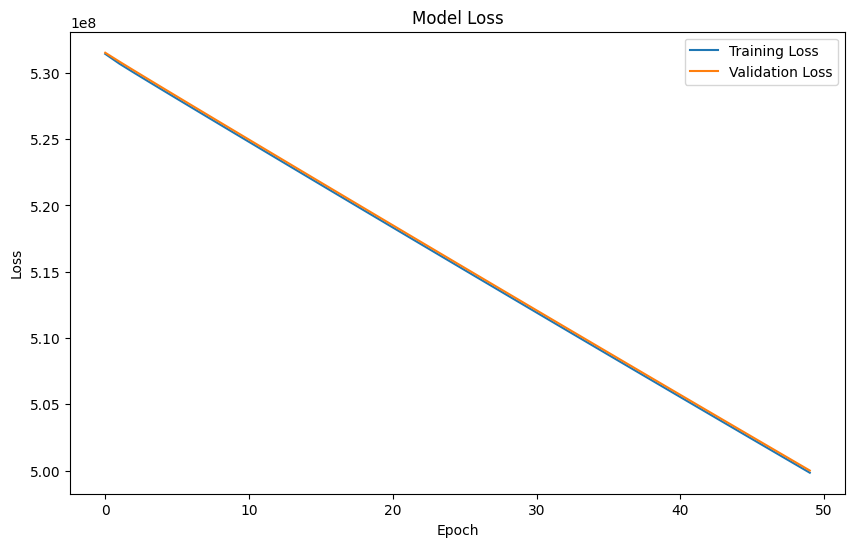

In [91]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [93]:
# Prepare a single input data point
single_input = X_test_scaled[0]  # Assuming you want to predict the first data point in the test set

# Reshape the single input data point to match the model's input shape
single_input_reshaped = single_input.reshape(1, window_size, num_features)

# Predict the output for the single input data point
predicted_price = model.predict(single_input_reshaped)

print("Predicted price:", predicted_price)

1/1 [==============================] - 0s 495ms/step
Predicted price: [[717.2997]]


1/1 [==============================] - 0s 36ms/step


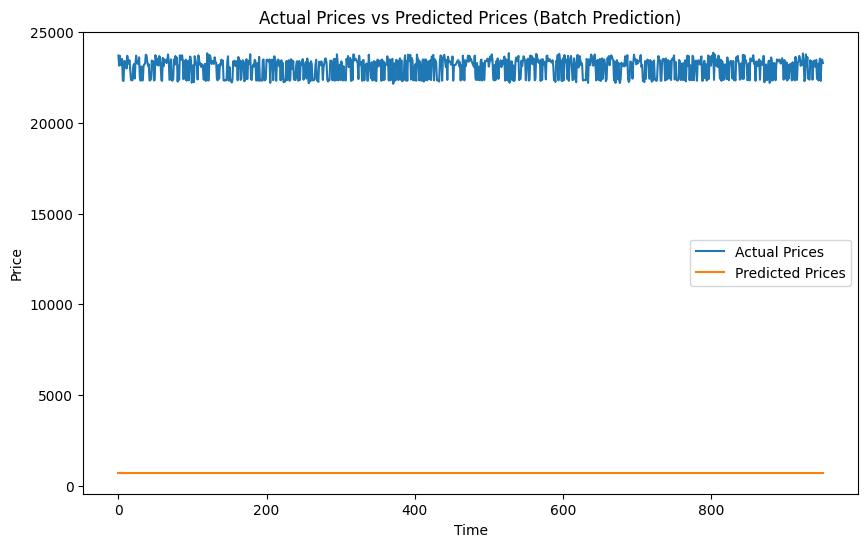

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns


batch_size = 32

all_predictions = []

for i in range(0, len(X_test_scaled), batch_size):

    batch_X_test = X_test_scaled[i:i+batch_size]


    batch_predictions = model.predict(batch_X_test)


    all_predictions.extend(batch_predictions)


all_predictions = np.array(all_predictions)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Prices')
plt.plot(all_predictions, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual Prices vs Predicted Prices (Batch Prediction)')
plt.legend()
plt.show()

In [96]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


y_pred = model.predict(X_test_scaled)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

30/30 [==============================] - 0s 7ms/step
MSE: 499656101.8377328
RMSE: 22352.98865560784
MAE: 22347.062181399906
R-squared: -1885.108966411705
